In [7]:
import torch
import os

os.chdir(r"C:\Users\cunn2\OneDrive\DSML\Project\thesis-repo")

run_path = r"sms/exp1/runs"

results = {}

for run in os.listdir(run_path):
    eval_path = os.path.join(run_path, run, "eval")
    run_results = {}
    for eval_file in os.listdir(eval_path):
        run_results[eval_file.replace('_eval.pt', '')] = torch.load(os.path.join(eval_path, eval_file))
    results[run] = run_results

C:\Users\cunn2\AppData\Local\Temp\ipykernel_187404\2423764498.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  run_results[eval_file.replace('_eval.pt', '')] = torch.loa

In [11]:
results['transformer_abs_1']['finetune_saved_model']['chunk']

dict_keys(['chunk_transposed', 'chunk_one_pitch_shifted', 'chunk_note_duration_changed', 'chunk_note_deleted', 'chunk_note_inserted', 'query_times'])

# using plotly - ugly!

In [21]:
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from plotly.subplots import make_subplots

def visualize_avg_recall(results, k_list, model_name):
    """
    Create a professional-looking line plot to visualize the average recall 
    for different augmentation types using Plotly.
    
    Args:
        results: The output dictionary from evaluate_search function
        k_list: List of k values used in the evaluation
        model_name: Name of the model being evaluated
    """
    aug_types = list(results.keys())
    if 'query_times' in aug_types:
        aug_types.remove('query_times')
    
    # Generate a color palette
    colors = px.colors.qualitative.D3[:len(aug_types)]
    
    # Create subplots: main plot and a zoomed-in section
    fig = make_subplots(rows=2, cols=1, row_heights=[0.7, 0.3], 
                        shared_xaxes=True, vertical_spacing=0.08,
                        subplot_titles=("Full Range", "Zoomed View (k=1 to 10)"))
    
    all_avg_recalls = []
    
    for aug_type, color in zip(aug_types, colors):
        avg_recalls = [results[aug_type]['top_k'][k]['avg_recall'] for k in k_list]
        all_avg_recalls.append(avg_recalls)
        
        # Main plot
        fig.add_trace(go.Scatter(
            x=k_list, y=avg_recalls, mode='lines+markers',
            name=aug_type, line=dict(color=color, width=2),
            marker=dict(size=8, symbol='circle')
        ), row=1, col=1)
        
        # Zoomed plot
        zoom_k = [k for k in k_list if k <= 10]
        zoom_recalls = avg_recalls[:len(zoom_k)]
        fig.add_trace(go.Scatter(
            x=zoom_k, y=zoom_recalls, mode='lines+markers',
            name=aug_type, line=dict(color=color, width=2),
            marker=dict(size=8, symbol='circle'), showlegend=False
        ), row=2, col=1)
    
    # Calculate and plot the average of all augmentations
    avg_of_avgs = np.mean(all_avg_recalls, axis=0)
    fig.add_trace(go.Scatter(
        x=k_list, y=avg_of_avgs, mode='lines+markers',
        name='Average', line=dict(color='black', width=3, dash='dash'),
        marker=dict(symbol='diamond', size=10, color='black')
    ), row=1, col=1)
    
    # Zoomed average plot
    zoom_avg = avg_of_avgs[:len(zoom_k)]
    fig.add_trace(go.Scatter(
        x=zoom_k, y=zoom_avg, mode='lines+markers',
        name='Average', line=dict(color='black', width=3, dash='dash'),
        marker=dict(symbol='diamond', size=10, color='black'), showlegend=False
    ), row=2, col=1)

    # Update layout for a professional look
    fig.update_layout(
        title=dict(
            text=f'Average Recall vs k for Different Augmentation Types<br><sup>{model_name}</sup>',
            font=dict(size=24)
        ),
        xaxis_title='k',
        yaxis_title='Average Recall',
        xaxis=dict(
            type='log',
            tickmode='array',
            tickvals=k_list,
            ticktext=[str(k) for k in k_list]
        ),
        xaxis2=dict(
            tickmode='array',
            tickvals=zoom_k,
            ticktext=[str(k) for k in zoom_k]
        ),
        legend=dict(
            title='Augmentation Type',
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=1.02
        ),
        hovermode='x unified',
        template='plotly_white',
        width=1000,
        height=800,
        font=dict(family="Arial", size=14),
    )

    # Update axes
    fig.update_xaxes(title_text="k", row=2, col=1)
    fig.update_yaxes(title_text="Average Recall", row=1, col=1)
    fig.update_yaxes(title_text="Average Recall", row=2, col=1)

    # Add a rectangle to highlight the zoomed area
    fig.add_shape(type="rect",
        x0=1, y0=min(avg_of_avgs), x1=10, y1=max(avg_of_avgs),
        line=dict(color="RoyalBlue", width=2),
        fillcolor="LightSkyBlue", opacity=0.2,
        row=1, col=1
    )

    # Save the plot as a static image file
    fig.write_image(f"{model_name}_top_k_evaluation_results.png", scale=2)
    fig.show()

# Usage
k_list = [1, 3, 5, 10, 25, 50, 100]
model_results = results['transformer_rel_big_1']['pretrain_saved_model']  # Assuming there's only one model in results
visualize_avg_recall(model_results, k_list, "Transformer Rel Big 1 (Pretrain)")

# seaborn

## top K search

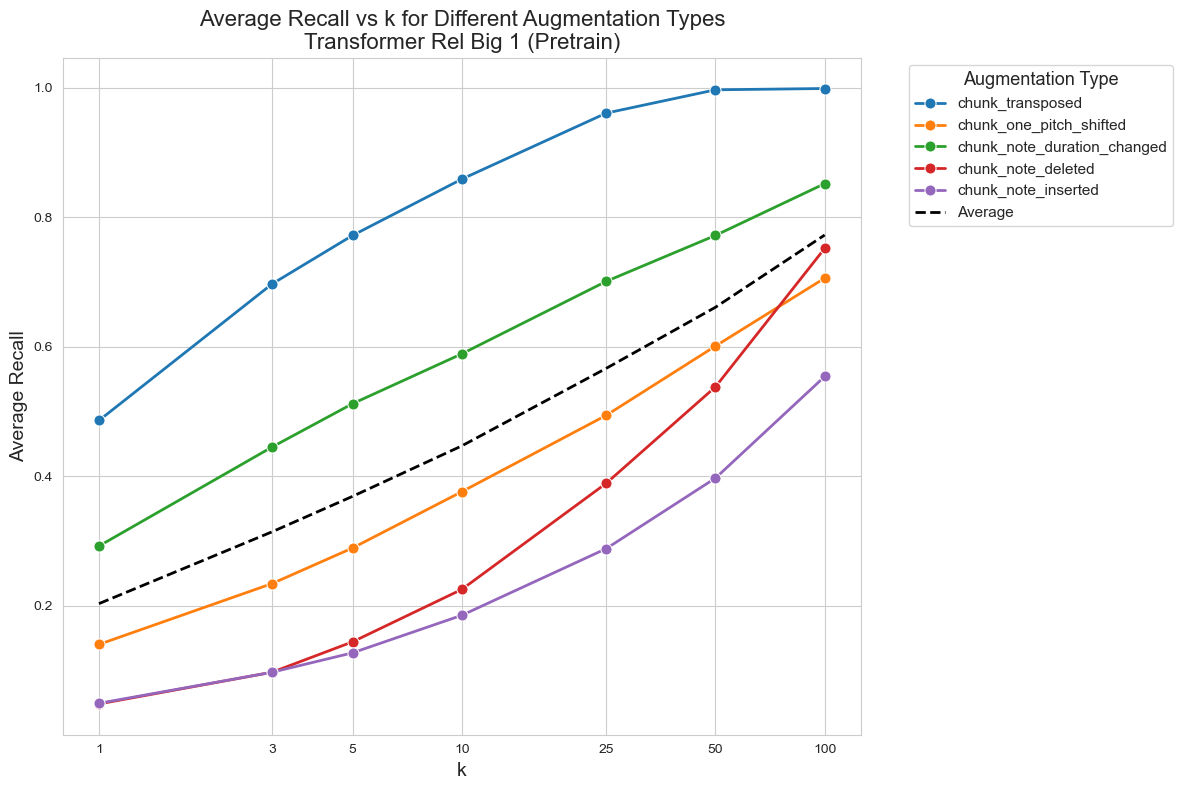

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def visualize_avg_recall(results, k_list, model_name):
    """
    Create a professional-looking line plot to visualize the average recall 
    for different augmentation types using Seaborn and Matplotlib.
    
    Args:
        results: The output dictionary from evaluate_search function
        k_list: List of k values used in the evaluation
        model_name: Name of the model being evaluated
    """
    aug_types = list(results.keys())
    if 'query_times' in aug_types:
        aug_types.remove('query_times')
    
    # Prepare data for plotting
    data = []
    for aug_type in aug_types:
        for k in k_list:
            data.append({
                'Augmentation': aug_type,
                'k': k,
                'Average Recall': results[aug_type]['top_k'][k]['avg_recall']
            })
    df = pd.DataFrame(data)
    
    # Set up the plot style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    
    # Create the main plot
    ax = sns.lineplot(data=df, x='k', y='Average Recall', hue='Augmentation', 
                      marker='o', linewidth=2, markersize=8)
    
    # Calculate and plot the average of all augmentations
    avg_data = df.groupby('k')['Average Recall'].mean().reset_index()
    sns.lineplot(data=avg_data, x='k', y='Average Recall', color='black', 
                 linestyle='--', linewidth=2, label='Average', ax=ax)
    
    # Customize the plot
    plt.xscale('log')
    plt.xticks(k_list, [str(k) for k in k_list])
    plt.xlabel('k', fontsize=14)
    plt.ylabel('Average Recall', fontsize=14)
    plt.title(f'Average Recall vs k for Different Augmentation Types\n{model_name}', fontsize=16)
    
    # Adjust legend
    plt.legend(title='Augmentation Type', title_fontsize='13', fontsize='11', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f"{model_name}_top_k_evaluation_results.png", dpi=300, bbox_inches='tight')
    plt.show()

# Usage
k_list = [1, 3, 5, 10, 25, 50, 100]
model_results = results['transformer_rel_big_1']['pretrain_saved_model']  # Assuming there's only one model in results
visualize_avg_recall(model_results, k_list, "Transformer Rel Big 1 (Pretrain)")

### top k averages across models

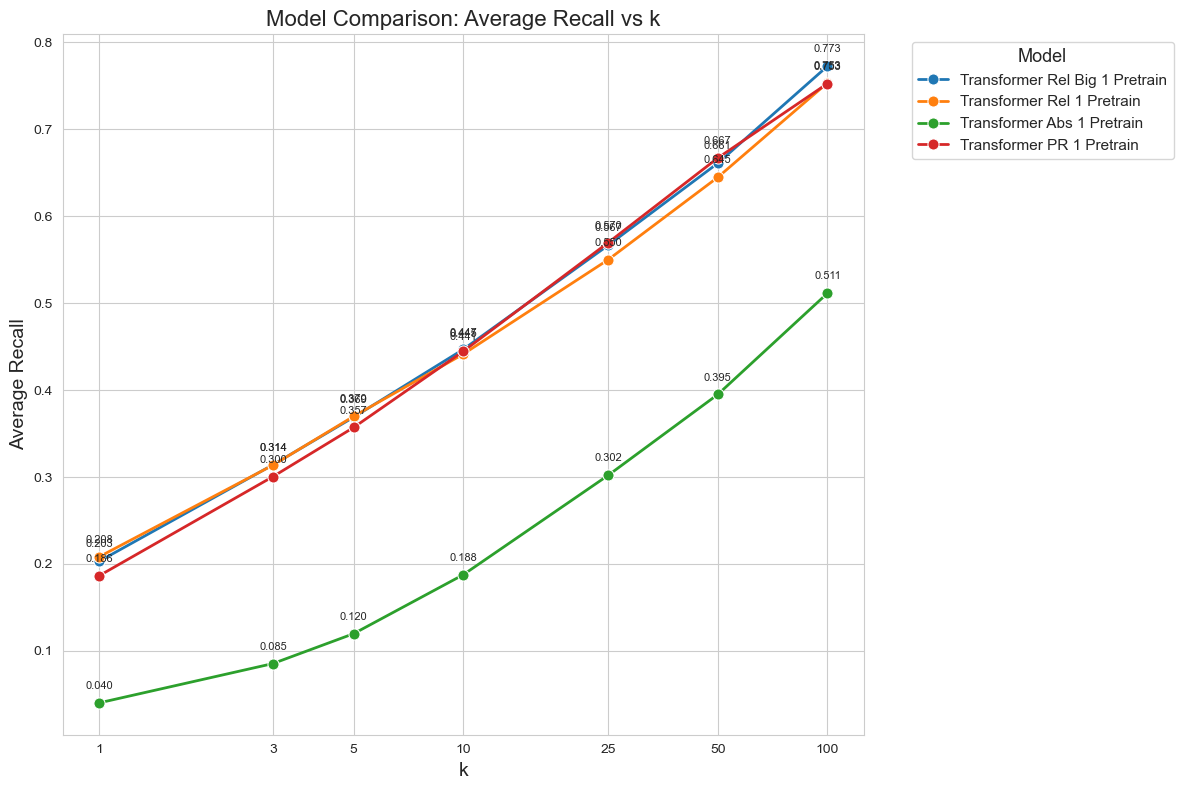

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_model_comparison(all_results, model_keys, k_list):
    """
    Create a line plot to compare average recall across different models.
    
    Args:
        all_results: Dictionary of results for each model
        model_keys: List of tuples, each containing (outer_key, inner_key, display_name) for each model
        k_list: List of k values used in the evaluation
    """
    # Prepare data for plotting
    data = []
    for outer_key, inner_key, display_name in model_keys:
        model_results = all_results[outer_key][inner_key]
        aug_types = [key for key in model_results.keys() if key != 'query_times']
        
        # Calculate average recall across all augmentation types
        avg_recalls = []
        for k in k_list:
            recalls = [model_results[aug_type]['top_k'][k]['avg_recall'] for aug_type in aug_types]
            avg_recalls.append(np.mean(recalls))
        
        for k, recall in zip(k_list, avg_recalls):
            data.append({
                'Model': display_name,
                'k': k,
                'Average Recall': recall
            })
    
    df = pd.DataFrame(data)
    
    # Set up the plot style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    
    # Create the main plot
    ax = sns.lineplot(data=df, x='k', y='Average Recall', hue='Model', 
                      marker='o', linewidth=2, markersize=8)
    
    # Customize the plot
    plt.xscale('log')
    plt.xticks(k_list, [str(k) for k in k_list])
    plt.xlabel('k', fontsize=14)
    plt.ylabel('Average Recall', fontsize=14)
    plt.title('Model Comparison: Average Recall vs k', fontsize=16)
    
    # Adjust legend
    plt.legend(title='Model', title_fontsize='13', fontsize='11', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add value labels
    for line in ax.lines:
        for x, y in zip(line.get_xdata(), line.get_ydata()):
            ax.annotate(f'{y:.3f}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=8)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig("model_comparison_top_k_results.png", dpi=300, bbox_inches='tight')
    plt.show()

# Usage
k_list = [1, 3, 5, 10, 25, 50, 100]
model_keys = [
    ('transformer_rel_big_1', 'pretrain_saved_model', 'Transformer Rel Big 1 Pretrain'),
    ('transformer_rel_1', 'pretrain_saved_model', 'Transformer Rel 1 Pretrain'),
    ('transformer_abs_1', 'pretrain_saved_model', 'Transformer Abs 1 Pretrain'),
    ('transformer_pr_1', 'pretrain_saved_model', 'Transformer PR 1 Pretrain')
]
visualize_model_comparison(results, model_keys, k_list)

# radius vis

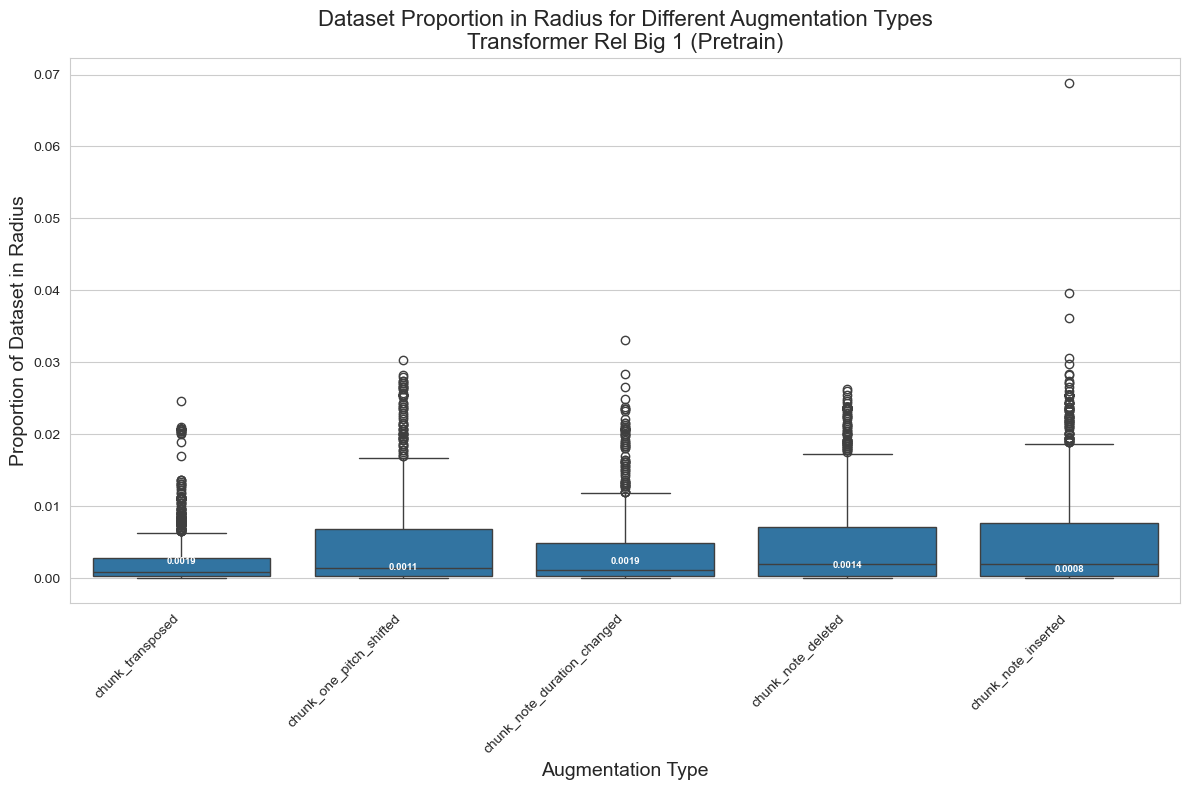

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def visualize_radius_search(results, model_name):
    """
    Create a box plot to visualize the dataset proportion in radius for different augmentation types.
    
    Args:
        results: The output dictionary from evaluate_search function
        model_name: Name of the model being evaluated
    """
    aug_types = list(results.keys())
    if 'query_times' in aug_types:
        aug_types.remove('query_times')
    
    # Prepare data for plotting
    data = []
    for aug_type in aug_types:
        percentages = results[aug_type]['radius']['dataset_proportion_in_radius']
        data.extend([{'Augmentation': aug_type, 'Proportion in Radius': p} for p in percentages])
    
    df = pd.DataFrame(data)
    
    # Set up the plot style
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 8))
    
    # Create the box plot
    ax = sns.boxplot(x='Augmentation', y='Proportion in Radius', data=df)
    
    # Customize the plot
    plt.xlabel('Augmentation Type', fontsize=14)
    plt.ylabel('Proportion of Dataset in Radius', fontsize=14)
    plt.title(f'Dataset Proportion in Radius for Different Augmentation Types\n{model_name}', fontsize=16)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add median values on top of each box
    medians = df.groupby('Augmentation')['Proportion in Radius'].median()
    for i, median in enumerate(medians):
        ax.text(i, median, f'{median:.4f}', horizontalalignment='center', size='x-small', color='w', weight='semibold')
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f"{model_name}_radius_search_results.png", dpi=300, bbox_inches='tight')
    plt.show()

# Usage
model_results = results['transformer_rel_big_1']['pretrain_saved_model']  # Adjust this to match your results structure
visualize_radius_search(model_results, "Transformer Rel Big 1 (Pretrain)")